In [1]:
import random
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import joblib
import pickle

import logging
from utils import *
from Lib.DataLoader import DataLoader

logging.basicConfig(level=logging.ERROR)

def load_split_data(file_path, num_fields, separator, skip_title, cls_col, start_feature_col, end_feature_col):
    dl = DataLoader()
    lines = dl.load_data_lines(file_path, num_fields=num_fields, separator=separator, skip_title=skip_title, shuffle=True)
    train_lines, val_lines = dl.split_data_by_cls_num(lines, cls_col)
    train_X = [[int(e) for e in l[start_feature_col:end_feature_col+1]] for l in train_lines]
    train_y = [int(l[cls_col]) for l in train_lines]
    val_X = [[int(e) for e in l[start_feature_col:end_feature_col+1]] for l in val_lines]
    val_y = [int(l[cls_col])for l in val_lines]
    val_id = [l[0:2] for l in val_lines]

    return train_X, train_y, val_X, val_y, val_id


def load_data(file_path, num_fields, separator, skip_title, cls_col, start_feature_col, end_feature_col):
    dl = DataLoader()
    lines = dl.load_data_lines(file_path, num_fields=num_fields, separator=separator, skip_title=skip_title, shuffle=True)
    X = [[int(e) for e in l[start_feature_col:end_feature_col+1]] for l in lines]
    y = [int(l[cls_col]) for l in lines]
    ids = [l[0:2] for l in lines]

    return X, y, ids

def load_data_arr(file_path_arr, num_fields, separator, skip_title, cls_col, start_feature_col, end_feature_col):
    X, y, ids = [], [], []
    for file_path in file_path_arr:
        X_, y_, ids_ = load_data(file_path, num_fields, separator, skip_title, cls_col, start_feature_col, end_feature_col)
        X.extend(X_)
        y.extend(y_)
        ids.extend(ids_)

    return X, y, ids


def write_pred_result(val_id, val_y, prediction, model_name):
    with open(r'data/%s.txt' % model_name, 'w') as f:
        for (id, dt), y, y_ in zip(val_id, val_y, prediction):
            f.write('%s,%s,%s,%s\n' % (id, dt, y, y_))

def run_test(scaler, model, X, y):
    X = scaler.transform(X)
    prediction = model.predict(X)
    matrix = metrics.confusion_matrix(y, prediction)
    accuracy = metrics.accuracy_score(y, prediction)
    print('准确率: {:.2%}'.format(accuracy))

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

font = FontProperties(fname="SimHei.ttf", size=14)
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        print(cm)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("显示百分比：")
#         np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
    else:
        cm_ = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
#         print('显示具体数字：')
#         print(cm_)
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # matplotlib版本问题，如果不加下面这行代码，则绘制的混淆矩阵上下只能显示一半，有的版本的matplotlib不需要下面的代码，分别试一下即可
    plt.ylim(len(classes) - 0.5, -0.5)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontproperties=font)
    plt.xlabel('Predicted label', fontproperties=font)
    plt.show()


In [3]:
tags = ["急性阑尾炎", "急性胰腺炎", "肠梗阻", "异位妊娠", "急性胆管炎", "急性胆囊炎", "上尿路结石", "卵巢囊肿破裂", "卵巢囊肿扭转", "消化道穿孔"]

def train_and_save(model, train_X, train_y, val_X, val_y, val_id, model_name):
    ss = StandardScaler()
    train_X = ss.fit_transform(train_X)
    val_X = ss.transform(val_X)

    # 用训练集做训练
    model.fit(train_X, train_y)
    # 用测试集做预测
    prediction=model.predict(val_X)
    # 混淆矩阵
    matrix = metrics.confusion_matrix(val_y, prediction)
    plot_confusion_matrix(matrix, tags, False, 'Confusion matrix')
    
    # 准确率
    accuracy = metrics.accuracy_score(val_y, prediction)
    print('准确率: {:.2%}'.format(accuracy))

    model_save_name = "%s_%.4f" % (model_name, accuracy)
    scaler_save_name = "scaler_%s" % (model_name)
    # 写结果
    write_pred_result(val_id, val_y, prediction, model_save_name)
    
    # 写模型
    joblib.dump(model, r"output/models/diagnose/%s.m" % model_save_name)
    
    # 保存标准化器
    pickle.dump(ss, open(r"output/models/diagnose/%s.pkl" % scaler_save_name, 'wb'))


In [69]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

model = GradientBoostingClassifier(max_features=90, max_depth=40, min_samples_split=8, min_samples_leaf=3, n_estimators=1200, learning_rate=0.05, subsample=0.95)
# model = BaggingClassifier(max_features=90, n_estimators=1200)
# model = ExtraTreesClassifier(max_features=90, max_depth=40, min_samples_split=8, min_samples_leaf=3, n_estimators=1200)
# model = RandomForestClassifier(max_features=90, max_depth=40, min_samples_split=8, min_samples_leaf=3, n_estimators=1200)
# model = AdaBoostClassifier(n_estimators=1200, learning_rate=0.05)
# model = LogisticRegression(random_state=1)
# model = GaussianNB()
# model = DecisionTreeClassifier(max_depth=90)
# model = SVC(gamma='scale', kernel='rbf', probability=True)

6


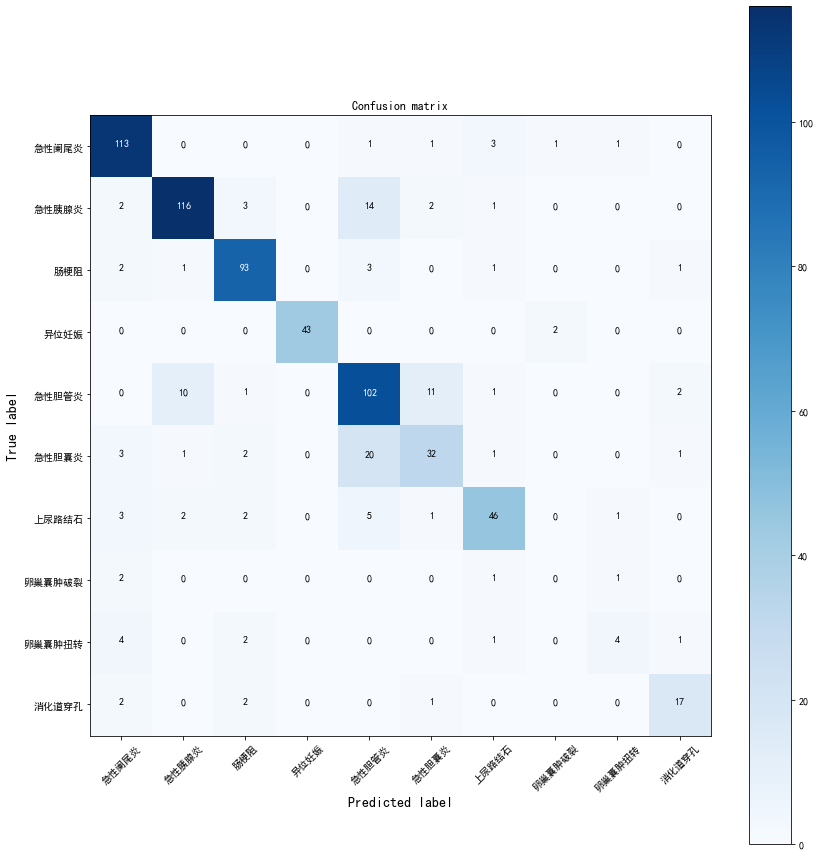

准确率: 82.15%


In [70]:
X_train, y_train, ids_train = load_data_arr([r'data/疾病诊断拟合_全特征_1.txt', r'data/疾病诊断拟合_全特征_2.txt', 
                           r'data/疾病诊断拟合_全特征_3.txt', r'data/疾病诊断拟合_全特征_4.txt'],
                          num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征_5.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)

train_and_save(model, X_train, y_train, X_val, y_val, ids_val, '测试_全量特征')

### 结果记录
GradientBoostingClassifier: 75.76%，83.16%，83.60%，82.15%
BaggingClassifier: 82.44%，82.73%，82.58%
ExtraTreesClassifier: 80.99%，80.70%，81.28%
RandomForestClassifier: 80.26%，80.12%，80.12%
AdaBoostClassifier: 61.97%，61.97%
LogisticRegression：73.58%，73.58%
GaussianNB：23.37%，23.37%
DecisionTreeClassifier：74.31%
SVC：76.92%
GradientBoostingClassifier + BaggingClassifier + ExtraTreesClassifier Voting：83.31%，83.45%

In [ ]:
X_train, y_train, ids_train = load_data_arr([r'data/疾病诊断拟合_全特征_1.txt', r'data/疾病诊断拟合_全特征_2.txt', 
                           r'data/疾病诊断拟合_全特征_3.txt', r'data/疾病诊断拟合_全特征_5.txt'],
                          num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征_4.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)

train_and_save(model, X_train, y_train, X_val, y_val, ids_val, 'gbdt_全量特征')

In [19]:
X_train, y_train, ids_train = load_data_arr([r'data/疾病诊断拟合_全特征_1.txt', r'data/疾病诊断拟合_全特征_2.txt', 
                           r'data/疾病诊断拟合_全特征_4.txt', r'data/疾病诊断拟合_全特征_5.txt'],
                          num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征_3.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)

train_and_save(model, X_train, y_train, X_val, y_val, ids_val, 'gbdt_全量特征')

6


KeyboardInterrupt: 